In [ ]:
#corre esta abby
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
#corre esta abby
data = pd.read_csv('vehicles_prep3 (2).csv')
data.head()


,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,33590,2014.0,gmc,good,8 cylinders,gas,57923,clean,other,4wd,pickup,white,al
1,22590,2010.0,chevrolet,good,8 cylinders,gas,71229,clean,other,4wd,pickup,blue,al
2,39590,2020.0,chevrolet,good,8 cylinders,gas,19160,clean,other,4wd,pickup,red,al
3,30990,2017.0,toyota,good,8 cylinders,gas,41124,clean,other,fwd,pickup,red,al
4,15000,2013.0,ford,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al


,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,33590,2014.0,gmc,good,8,gas,57923,clean,other,4wd,pickup,white,al
1,22590,2010.0,chevrolet,good,8,gas,71229,clean,other,4wd,pickup,blue,al
2,39590,2020.0,chevrolet,good,8,gas,19160,clean,other,4wd,pickup,red,al
3,30990,2017.0,toyota,good,8,gas,41124,clean,other,fwd,pickup,red,al
4,15000,2013.0,ford,excellent,6,gas,128000,clean,automatic,rwd,truck,black,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375170,23590,2019.0,nissan,good,6,gas,32226,clean,other,fwd,sedan,silver,wy
375171,30590,2020.0,volvo,good,4,gas,12029,clean,other,fwd,sedan,red,wy
375172,34990,2020.0,cadillac,good,6,diesel,4174,clean,other,4wd,hatchback,white,wy
375173,28990,2018.0,lexus,good,6,gas,30112,clean,other,fwd,sedan,silver,wy


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375175 entries, 0 to 375174
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         375175 non-null  int64  
 1   year          375175 non-null  float64
 2   manufacturer  375174 non-null  object 
 3   condition     375175 non-null  object 
 4   cylinders     375175 non-null  object 
 5   fuel          375175 non-null  object 
 6   odometer      375175 non-null  int64  
 7   title_status  375175 non-null  object 
 8   transmission  375175 non-null  object 
 9   drive         375175 non-null  object 
 10  type          375175 non-null  object 
 11  paint_color   375175 non-null  object 
 12  state         375175 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 37.2+ MB


# Ridge Model

In [ ]:
# 1) Agrupar categorías raras: top 10 + "Other"
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    top10 = df[col].value_counts().nlargest(10).index
    df[col] = df[col].where(df[col].isin(top10), other='Other')

# 2) Prepara X/y y split
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) ColumnTransformer con sparse encoding
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', Pipeline([
         ('imputer', SimpleImputer(strategy='mean')),
         ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
         ('imputer', SimpleImputer(strategy='most_frequent')),
         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]), cat_cols)
], sparse_threshold=0.1)

# 4) Muestra para buscar α
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train, train_size=50000, random_state=42
)
X_sub_trans = preprocessor.fit_transform(X_sub)

alphas = np.logspace(0, 3, 10)
best_alpha, best_mse = None, np.inf
for a in alphas:
    m = Ridge(alpha=a).fit(X_sub_trans, y_sub)
    mse = mean_squared_error(y_sub, m.predict(X_sub_trans))
    if mse < best_mse:
        best_mse, best_alpha = mse, a

print("α candidato:", best_alpha)

# 5) Entrena Ridge final con ese α
model = Pipeline([
    ('preproc', preprocessor),
    ('ridge', Ridge(alpha=best_alpha*2))   # puedes ajustar factor para asegurar fuerte regularización
])
model.fit(X_train, y_train)

y_tr = model.predict(X_train)
y_te = model.predict(X_test)
r2_tr = r2_score(y_train, y_tr)
r2_te = r2_score(y_test, y_te)
overf = (r2_tr - r2_te)/abs(r2_tr)*100

mse_tr = mean_squared_error(y_train, y_tr)
mse_te = mean_squared_error(y_test, y_te)

rmse_tr = np.sqrt(mse_tr)
rmse_te = np.sqrt(mse_te)

print(f"MSE Train: {mse_tr:.2f}")
print(f"MSE Test:  {mse_te:.2f}")
print(f"RMSE Train: {rmse_tr:.2f}")
print(f"RMSE Test:  {rmse_te:.2f}")

print(f"R² Train: {r2_tr:.4f}")
print(f"R² Test:  {r2_te:.4f}")
print(f"Overfitting: {overf:.2f}%")

α candidato: 1.0
MSE Train: 83212448.87
MSE Test:  84448204.81
RMSE Train: 9122.09
RMSE Test:  9189.57
R² Train: 0.5876
R² Test:  0.5835
Overfitting: 0.70%


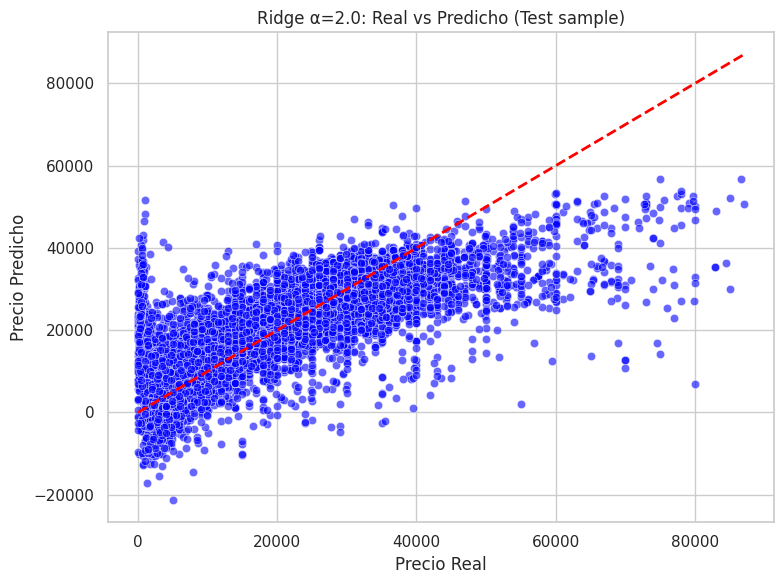

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Carga y agrupa categorías raras
df = pd.read_csv('vehicles_prep.csv')
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    top10 = df[col].value_counts().nlargest(10).index
    df[col] = df[col].where(df[col].isin(top10), other='Other')

# Split inicial
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Muestras para entrenamiento & test (para gráfico)
X_train_s = X_train.sample(50000, random_state=42)
y_train_s = y_train.loc[X_train_s.index]
X_test_s  = X_test.sample(10000, random_state=42)
y_test_s  = y_test.loc[X_test_s.index]

# Preprocesamiento
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')),
                      ('scaler', StandardScaler())]), num_cols),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                      ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
], sparse_threshold=0)

# Modelo Ridge con α=2.0
model = Pipeline([
    ('preproc', preprocessor),
    ('ridge', Ridge(alpha=2.0))
])
model.fit(X_train_s, y_train_s)

# Predicciones y R² sobre la muestra
y_tr_s = model.predict(X_train_s)
y_te_s = model.predict(X_test_s)
r2_tr_s = r2_score(y_train_s, y_tr_s)
r2_te_s = r2_score(y_test_s, y_te_s)

# Gráfica 1: Real vs Predicho (Test sample) con Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_s, y=y_te_s, alpha=0.6, color='blue')
plt.plot([y_test_s.min(), y_test_s.max()],
         [y_test_s.min(), y_test_s.max()],
         '--', color='red', linewidth=2)
plt.xlabel("Precio Real")
plt.ylabel("Precio Predicho")
plt.title("Ridge α=2.0: Real vs Predicho (Test sample)")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-64-1a2048ddb4de>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Train R²", "Test R²"], y=[r2_tr_s, r2_te_s], palette="Blues_d")


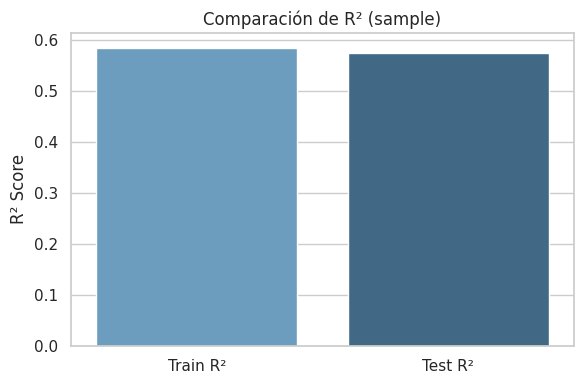

In [ ]:
# Gráfica 2: Comparación de R² (sample) con Seaborn
plt.figure(figsize=(6, 4))
sns.barplot(x=["Train R²", "Test R²"], y=[r2_tr_s, r2_te_s], palette="Blues_d")
plt.ylabel("R² Score")
plt.title("Comparación de R² (sample)")
plt.tight_layout()
plt.show()


#Linear Regression

In [ ]:
#corre esta abby
data= data[data['cylinders'] != 'other']


In [ ]:
#corre esta abby
print(data["cylinders"].unique())

['8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' '10 cylinders'
 '3 cylinders' '12 cylinders']


In [ ]:
#corre esta abby
# Eliminar la palabra "cylinders" y convertir a int
data['cylinders'] = data['cylinders'].str.replace(' cylinders', '').astype(int)

# Verificar que la conversión fue exitosa
print(data['cylinders'].dtype)  # Debe ser 'int'


int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. Separar variables predictoras y objetivo
X = data.drop('price', axis=1)
y = data['price']

# 2. Codificación One-Hot para variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 4. Escalado de variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Entrenamiento del modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 6. Predicciones y evaluación
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# 7. Cálculo de MSE y RMSE
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# 8. Cálculo de R²
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# 9. Cálculo de Overfitting (basado en RMSE)
overfitting = 100 * abs(rmse_test - rmse_train) / rmse_train

# Resultados
print(f"🔍 Evaluación del modelo de Regresión Lineal:")
print(f" - MSE Train: {mse_train:.2f}")
print(f" - MSE Test: {mse_test:.2f}")
print(f" - RMSE Train: {rmse_train:.2f}")
print(f" - RMSE Test: {rmse_test:.2f}")
print(f" - R² Train: {r2_train:.2f}")
print(f" - R² Test: {r2_test:.2f}")
print(f" - Overfitting: {overfitting:.2f}%")


🔍 Evaluación del modelo de Regresión Lineal:
 - MSE Train: 79712555.95
 - MSE Test: 79713258.00
 - RMSE Train: 8928.19
 - RMSE Test: 8928.23
 - R² Train: 0.60
 - R² Test: 0.61
 - Overfitting: 0.00%


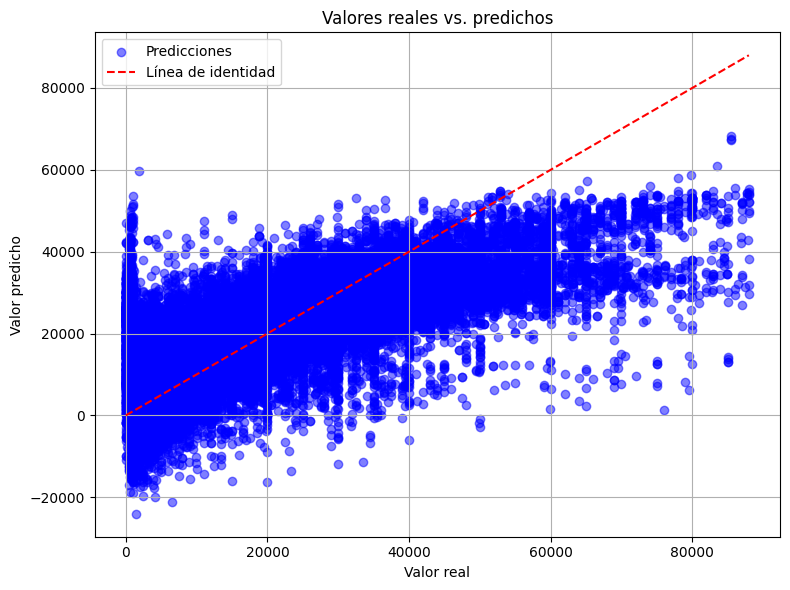

In [ ]:
import matplotlib.pyplot as plt

# Gráfico de dispersión de valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Línea de identidad")
plt.title('Valores reales vs. predichos')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Vamos a intentar mejorar el modelo

🔍 Evaluación del modelo con log(price):
 - MSE Train: 95598620.26
 - MSE Test: 95774759.62
 - RMSE Train: 9777.45
 - RMSE Test: 9786.46
 - R² Train: 0.52
 - R² Test: 0.53
 - Overfitting: 0.09%


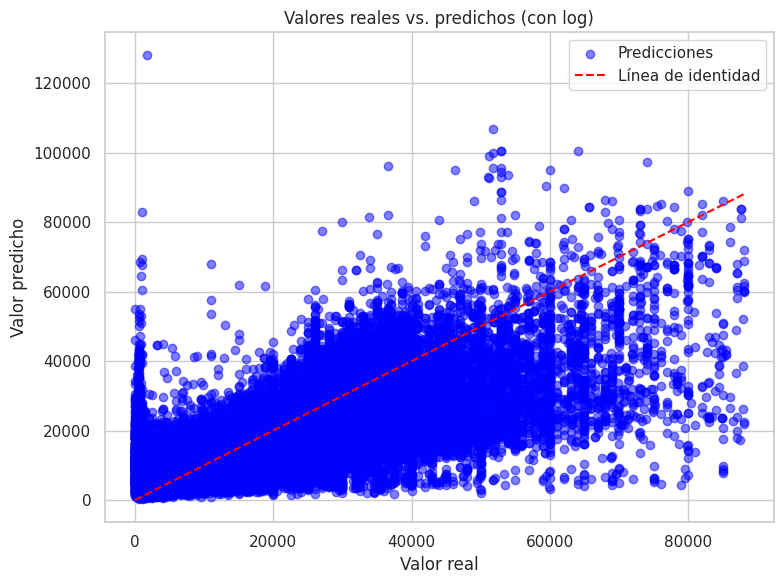

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Separar variables predictoras y objetivo
X = data.drop('price', axis=1)
y = data['price']

# 2. Codificación One-Hot para variables categóricas (si no está hecho ya)
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. Transformar y con logaritmo (log1p para manejar ceros)
y_log = np.log1p(y)

# 4. División en entrenamiento y prueba
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_encoded, y_log, test_size=0.2, random_state=42
)

# 5. Escalado de variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Entrenamiento del modelo
model = LinearRegression()
model.fit(X_train_scaled, y_train_log)

# 7. Predicciones en escala logarítmica y destransformación
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)       # volver a escala original
y_test = np.expm1(y_test_log)       # volver a escala original para comparar

# 8. Evaluación
mse_train = mean_squared_error(y_train, np.expm1(model.predict(X_train_scaled)))
mse_test = mean_squared_error(y_test, y_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, np.expm1(model.predict(X_train_scaled)))
r2_test = r2_score(y_test, y_pred)
overfitting = 100 * abs(rmse_test - rmse_train) / rmse_train

print("🔍 Evaluación del modelo con log(price):")
print(f" - MSE Train: {mse_train:.2f}")
print(f" - MSE Test: {mse_test:.2f}")
print(f" - RMSE Train: {rmse_train:.2f}")
print(f" - RMSE Test: {rmse_test:.2f}")
print(f" - R² Train: {r2_train:.2f}")
print(f" - R² Test: {r2_test:.2f}")
print(f" - Overfitting: {overfitting:.2f}%")

# 9. Gráfico real vs. predicho
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         color='red', linestyle='--', label="Línea de identidad")
plt.title('Valores reales vs. predichos (con log)')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Random Forest

## Random Rorest 1

🌲 Random Forest (sin log):
 - RMSE: 5061.80
 - R²: 0.87

🌲 Random Forest (con log):
 - RMSE: 5862.76
 - R²: 0.83


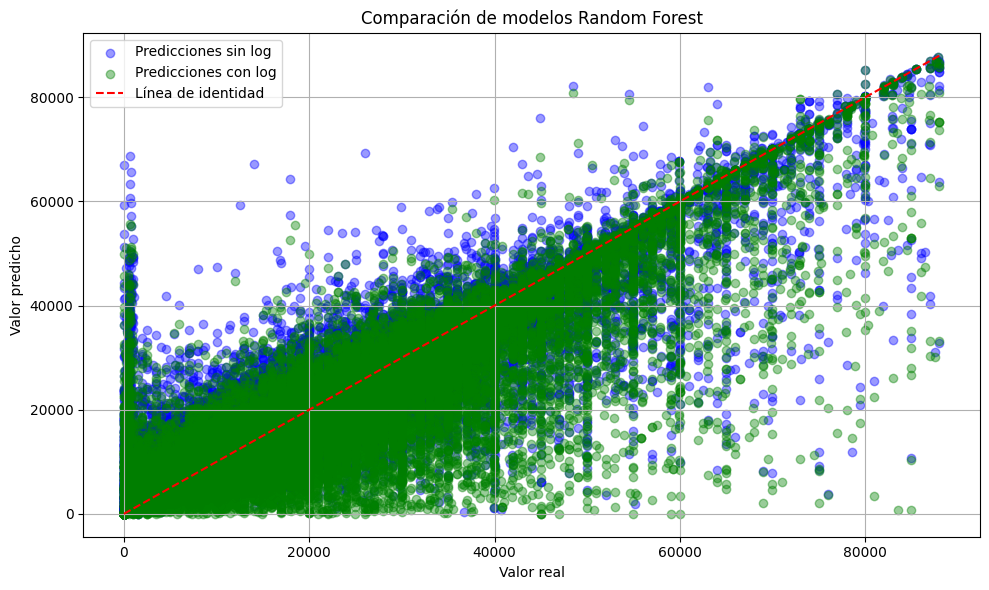

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Separar variables predictoras y objetivo
X = data.drop('price', axis=1)
y = data['price']

# 2. One-Hot Encoding (si no está hecho aún)
X_encoded = pd.get_dummies(X, drop_first=True)

# 3. División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# 4. Escalado de variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== MODELO 1: Random Forest SIN transformación log ==========
rf_plain = RandomForestRegressor(n_estimators=100, random_state=42)
rf_plain.fit(X_train_scaled, y_train)

y_pred_plain = rf_plain.predict(X_test_scaled)

rmse_plain = np.sqrt(mean_squared_error(y_test, y_pred_plain))
r2_plain = r2_score(y_test, y_pred_plain)

print("🌲 Random Forest (sin log):")
print(f" - RMSE: {rmse_plain:.2f}")
print(f" - R²: {r2_plain:.2f}")

# ========== MODELO 2: Random Forest CON log(price) ==========
y_log = np.log1p(y)  # transformación logarítmica
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

rf_log = RandomForestRegressor(n_estimators=100, random_state=42)
rf_log.fit(X_train_scaled, y_train_log)

y_pred_log = rf_log.predict(X_test_scaled)
y_pred_log_inverse = np.expm1(y_pred_log)  # destransformación
y_test_inverse = np.expm1(y_test_log)

rmse_log = np.sqrt(mean_squared_error(y_test_inverse, y_pred_log_inverse))
r2_log = r2_score(y_test_inverse, y_pred_log_inverse)

print("\n🌲 Random Forest (con log):")
print(f" - RMSE: {rmse_log:.2f}")
print(f" - R²: {r2_log:.2f}")

# ========== Gráfico de valores reales vs. predichos ==========
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_plain, alpha=0.4, label="Predicciones sin log", color='blue')
plt.scatter(y_test, y_pred_log_inverse, alpha=0.4, label="Predicciones con log", color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Línea de identidad")
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Comparación de modelos Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score

# ========== MÉTRICAS para el modelo sin transformación log ==========

# Error absoluto medio (MAE)
mae_plain = mean_absolute_error(y_test, y_pred_plain)

# Error cuadrático medio (RMSE) ya calculado anteriormente
rmse_plain = np.sqrt(mean_squared_error(y_test, y_pred_plain))

# Coeficiente de determinación ajustado (R² ajustado)
n = len(y_test)  # número de observaciones
p = X_test_scaled.shape[1]  # número de predictores
r2_adj_plain = 1 - (1 - r2_plain) * (n - 1) / (n - p - 1)

# ========== MÉTRICAS para el modelo con log transformación ==========

# Error absoluto medio (MAE) con log
mae_log = mean_absolute_error(y_test_inverse, y_pred_log_inverse)

# Error cuadrático medio (RMSE) con log ya calculado anteriormente
rmse_log = np.sqrt(mean_squared_error(y_test_inverse, y_pred_log_inverse))

# Coeficiente de determinación ajustado (R² ajustado) con log
r2_adj_log = 1 - (1 - r2_log) * (n - 1) / (n - p - 1)

# Error cuadrático medio logarítmico (MSLE)
msle_log = mean_squared_log_error(y_test_inverse, y_pred_log_inverse)

# ========== Resultados y Métricas ==========

# Resultados para el modelo sin log
print("🌲 Random Forest (sin log):")
print(f" - RMSE: {rmse_plain:.2f}")
print(f" - R²: {r2_plain:.2f}")
print(f" - R² Ajustado: {r2_adj_plain:.2f}")
print(f" - MAE: {mae_plain:.2f}")
print(f" - MSLE: {msle_log:.2f}")

# Resultados para el modelo con log
print("\n🌲 Random Forest (con log):")
print(f" - RMSE: {rmse_log:.2f}")
print(f" - R²: {r2_log:.2f}")
print(f" - R² Ajustado: {r2_adj_log:.2f}")
print(f" - MAE: {mae_log:.2f}")
print(f" - MSLE: {msle_log:.2f}")


🌲 Random Forest (sin log):
 - RMSE: 5061.80
 - R²: 0.87
 - R² Ajustado: 0.87
 - MAE: 2401.25
 - MSLE: 0.45

🌲 Random Forest (con log):
 - RMSE: 5862.76
 - R²: 0.83
 - R² Ajustado: 0.83
 - MAE: 2741.95
 - MSLE: 0.45


In [ ]:
# ================== Cálculo de MSE y RMSE para entrenamiento y prueba ==================

# Cálculo de MSE (Mean Squared Error) para entrenamiento y prueba
mse_train_plain = mean_squared_error(y_train, y_pred_train_plain)
mse_test_plain = mean_squared_error(y_test, y_pred_plain)

# Cálculo de RMSE (Root Mean Squared Error) para entrenamiento y prueba
rmse_train_plain = np.sqrt(mse_train_plain)
rmse_test_plain = np.sqrt(mse_test_plain)

# ================== Cálculo de R² para entrenamiento y prueba ==================
r2_train_plain = r2_score(y_train, y_pred_train_plain)
r2_test_plain = r2_score(y_test, y_pred_plain)

# ================== Detección de Overfitting ==================
# Calculando el Overfitting en términos relativos
overfitting_percentage = (rmse_test_plain - rmse_train_plain) / rmse_train_plain * 100

# ================== Imprimir los resultados ==================

print(f"MSE Train: {mse_train_plain:.2f}")
print(f"MSE Test:  {mse_test_plain:.2f}")
print(f"RMSE Train: {rmse_train_plain:.2f}")
print(f"RMSE Test:  {rmse_test_plain:.2f}")
print(f"R² Train: {r2_train_plain:.4f}")
print(f"R² Test:  {r2_test_plain:.4f}")
print(f"Overfitting: {overfitting_percentage:.2f}%")


MSE Train: 3820829.04
MSE Test:  25621796.40
RMSE Train: 1954.69
RMSE Test:  5061.80
R² Train: 0.9810
R² Test:  0.8739
Overfitting: 158.96%


Como se observa el overfitting de este modelo es completamente desmesurado, tenemos que hacer cambios

## Random Forest 2

In [ ]:
# Random Forest con parámetros más restrictivos
rf_tuned = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=10, random_state=42)

# Entrenar el modelo ajustado
rf_tuned.fit(X_train_scaled, y_train)

# Hacer predicciones
y_pred_train_tuned = rf_tuned.predict(X_train_scaled)
y_pred_test_tuned = rf_tuned.predict(X_test_scaled)

# Cálculo de métricas
mse_train_tuned = mean_squared_error(y_train, y_pred_train_tuned)
mse_test_tuned = mean_squared_error(y_test, y_pred_test_tuned)
rmse_train_tuned = np.sqrt(mse_train_tuned)
rmse_test_tuned = np.sqrt(mse_test_tuned)
r2_train_tuned = r2_score(y_train, y_pred_train_tuned)
r2_test_tuned = r2_score(y_test, y_pred_test_tuned)

# Mostrar resultados
print(f"MSE Train (tuned): {mse_train_tuned:.2f}")
print(f"MSE Test (tuned): {mse_test_tuned:.2f}")
print(f"RMSE Train (tuned): {rmse_train_tuned:.2f}")
print(f"RMSE Test (tuned): {rmse_test_tuned:.2f}")
print(f"R² Train (tuned): {r2_train_tuned:.4f}")
print(f"R² Test (tuned): {r2_test_tuned:.4f}")


MSE Train (tuned): 53833416.39
MSE Test (tuned): 55340577.12
RMSE Train (tuned): 7337.13
RMSE Test (tuned): 7439.12
R² Train (tuned): 0.7324
R² Test (tuned): 0.7275


In [ ]:
# Nuevos valores de RMSE
rmse_train_tuned = 7337.13
rmse_test_tuned = 7439.12

# Cálculo del Overfitting
overfitting_percentage_tuned = ((rmse_test_tuned - rmse_train_tuned) / rmse_train_tuned) * 100

# Imprimir el resultado
print(f"Overfitting: {overfitting_percentage_tuned:.2f}%")

Overfitting: 1.39%


## Random Forest 3

In [ ]:
rf_alternativo = RandomForestRegressor(
    n_estimators=100,         # más árboles = mayor capacidad
    max_depth=15,             # más profundidad = más complejidad permitida
    min_samples_split=5,      # permite divisiones más pequeñas = más flexible
    random_state=42
)

rf_alternativo.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train_alt = rf_alternativo.predict(X_train_scaled)
y_pred_test_alt = rf_alternativo.predict(X_test_scaled)

# Métricas
mse_train_alt = mean_squared_error(y_train, y_pred_train_alt)
mse_test_alt = mean_squared_error(y_test, y_pred_test_alt)
rmse_train_alt = np.sqrt(mse_train_alt)
rmse_test_alt = np.sqrt(mse_test_alt)
r2_train_alt = r2_score(y_train, y_pred_train_alt)
r2_test_alt = r2_score(y_test, y_pred_test_alt)

# Overfitting relativo (%)
overfitting_alt = 100 * abs(rmse_test_alt - rmse_train_alt) / rmse_train_alt

# Mostrar
print(f"MSE Train (alt): {mse_train_alt:.2f}")
print(f"MSE Test (alt): {mse_test_alt:.2f}")
print(f"RMSE Train (alt): {rmse_train_alt:.2f}")
print(f"RMSE Test (alt): {rmse_test_alt:.2f}")
print(f"R² Train (alt): {r2_train_alt:.4f}")
print(f"R² Test (alt): {r2_test_alt:.4f}")
print(f"Overfitting (alt): {overfitting_alt:.2f}%")


MSE Train (alt): 34343049.70
MSE Test (alt): 40944174.95
RMSE Train (alt): 5860.29
RMSE Test (alt): 6398.76
R² Train (alt): 0.8293
R² Test (alt): 0.7984
Overfitting (alt): 9.19%


## Random Forest 4

In [ ]:
# Random Forest con parámetros ajustados para reducir el overfitting
rf_alternativo_ajustado = RandomForestRegressor(
    n_estimators=100,           # Mantener el número de árboles (puedes probar reducirlo si es necesario)
    max_depth=10,               # Menos profundidad para evitar el sobreajuste
    min_samples_split=10,       # Mayor número de muestras necesarias para dividir un nodo
    min_samples_leaf=5,         # Asegura que haya al menos 5 muestras por hoja
    random_state=42
)

# Entrenar el modelo ajustado
rf_alternativo_ajustado.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train_alt_ajustado = rf_alternativo_ajustado.predict(X_train_scaled)
y_pred_test_alt_ajustado = rf_alternativo_ajustado.predict(X_test_scaled)

# Cálculo de métricas
mse_train_alt_ajustado = mean_squared_error(y_train, y_pred_train_alt_ajustado)
mse_test_alt_ajustado = mean_squared_error(y_test, y_pred_test_alt_ajustado)
rmse_train_alt_ajustado = np.sqrt(mse_train_alt_ajustado)
rmse_test_alt_ajustado = np.sqrt(mse_test_alt_ajustado)
r2_train_alt_ajustado = r2_score(y_train, y_pred_train_alt_ajustado)
r2_test_alt_ajustado = r2_score(y_test, y_pred_test_alt_ajustado)

# Overfitting relativo (%)
overfitting_alt_ajustado = 100 * abs(rmse_test_alt_ajustado - rmse_train_alt_ajustado) / rmse_train_alt_ajustado

# Mostrar resultados ajustados
print(f"MSE Train (alt ajustado): {mse_train_alt_ajustado:.2f}")
print(f"MSE Test (alt ajustado): {mse_test_alt_ajustado:.2f}")
print(f"RMSE Train (alt ajustado): {rmse_train_alt_ajustado:.2f}")
print(f"RMSE Test (alt ajustado): {rmse_test_alt_ajustado:.2f}")
print(f"R² Train (alt ajustado): {r2_train_alt_ajustado:.4f}")
print(f"R² Test (alt ajustado): {r2_test_alt_ajustado:.4f}")
print(f"Overfitting (alt ajustado): {overfitting_alt_ajustado:.2f}%")


MSE Train (alt ajustado): 54046001.98
MSE Test (alt ajustado): 55390136.84
RMSE Train (alt ajustado): 7351.60
RMSE Test (alt ajustado): 7442.46
R² Train (alt ajustado): 0.7314
R² Test (alt ajustado): 0.7273
Overfitting (alt ajustado): 1.24%


## Random Forest 5

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Modelo ajustado con un poco más de complejidad
rf_ajustado_mas_complejo = RandomForestRegressor(
    n_estimators=150,         # más árboles = más potencia
    max_depth=18,             # más profundidad permite más detalles
    min_samples_split=5,      # igual que antes, lo mantenemos flexible
    random_state=42
)

# Entrenamiento
rf_ajustado_mas_complejo.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train_plus = rf_ajustado_mas_complejo.predict(X_train_scaled)
y_pred_test_plus = rf_ajustado_mas_complejo.predict(X_test_scaled)

# Métricas
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse_train_plus = mean_squared_error(y_train, y_pred_train_plus)
mse_test_plus = mean_squared_error(y_test, y_pred_test_plus)
rmse_train_plus = np.sqrt(mse_train_plus)
rmse_test_plus = np.sqrt(mse_test_plus)
r2_train_plus = r2_score(y_train, y_pred_train_plus)
r2_test_plus = r2_score(y_test, y_pred_test_plus)
overfitting_plus = 100 * abs(rmse_test_plus - rmse_train_plus) / rmse_train_plus

# Resultados
print(f"MSE Train (plus): {mse_train_plus:.2f}")
print(f"MSE Test (plus): {mse_test_plus:.2f}")
print(f"RMSE Train (plus): {rmse_train_plus:.2f}")
print(f"RMSE Test (plus): {rmse_test_plus:.2f}")
print(f"R² Train (plus): {r2_train_plus:.4f}")
print(f"R² Test (plus): {r2_test_plus:.4f}")
print(f"Overfitting (plus): {overfitting_plus:.2f}%")


MSE Train (plus): 25702130.56
MSE Test (plus): 35693823.57
RMSE Train (plus): 5069.73
RMSE Test (plus): 5974.43
R² Train (plus): 0.8723
R² Test (plus): 0.8243
Overfitting (plus): 17.85%


## Random forest 6

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Modelo balanceado
rf_balanceado = RandomForestRegressor(
    n_estimators=120,
    max_depth=14,
    min_samples_split=6,
    random_state=42
)

# Entrenar
rf_balanceado.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train_bal = rf_balanceado.predict(X_train_scaled)
y_pred_test_bal = rf_balanceado.predict(X_test_scaled)

# Métricas
mse_train_bal = mean_squared_error(y_train, y_pred_train_bal)
mse_test_bal = mean_squared_error(y_test, y_pred_test_bal)
rmse_train_bal = np.sqrt(mse_train_bal)
rmse_test_bal = np.sqrt(mse_test_bal)
r2_train_bal = r2_score(y_train, y_pred_train_bal)
r2_test_bal = r2_score(y_test, y_pred_test_bal)
overfitting_bal = 100 * abs(rmse_test_bal - rmse_train_bal) / rmse_train_bal

# Resultados
print(f"MSE Train (balanceado): {mse_train_bal:.2f}")
print(f"MSE Test (balanceado): {mse_test_bal:.2f}")
print(f"RMSE Train (balanceado): {rmse_train_bal:.2f}")
print(f"RMSE Test (balanceado): {rmse_test_bal:.2f}")
print(f"R² Train (balanceado): {r2_train_bal:.4f}")
print(f"R² Test (balanceado): {r2_test_bal:.4f}")
print(f"Overfitting (balanceado): {overfitting_bal:.2f}%")


MSE Train (balanceado): 37859225.67
MSE Test (balanceado): 43218147.50
RMSE Train (balanceado): 6152.99
RMSE Test (balanceado): 6574.05
R² Train (balanceado): 0.8118
R² Test (balanceado): 0.7872
Overfitting (balanceado): 6.84%


## Random Forest 7

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_balanceado_refinado = RandomForestRegressor(
    n_estimators=80,           # un poco menos árboles
    max_depth=12,              # reduce profundidad máxima
    min_samples_split=8,       # más muestras para dividir = menos sobreajuste
    random_state=42
)

# Entrenar el modelo
rf_balanceado_refinado.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train_bal = rf_balanceado_refinado.predict(X_train_scaled)
y_pred_test_bal = rf_balanceado_refinado.predict(X_test_scaled)

# Métricas
mse_train_bal = mean_squared_error(y_train, y_pred_train_bal)
mse_test_bal = mean_squared_error(y_test, y_pred_test_bal)
rmse_train_bal = np.sqrt(mse_train_bal)
rmse_test_bal = np.sqrt(mse_test_bal)
r2_train_bal = r2_score(y_train, y_pred_train_bal)
r2_test_bal = r2_score(y_test, y_pred_test_bal)
overfitting_bal = 100 * abs(rmse_test_bal - rmse_train_bal) / rmse_train_bal

# Resultados
print(f"MSE Train (refinado): {mse_train_bal:.2f}")
print(f"MSE Test (refinado): {mse_test_bal:.2f}")
print(f"RMSE Train (refinado): {rmse_train_bal:.2f}")
print(f"RMSE Test (refinado): {rmse_test_bal:.2f}")
print(f"R² Train (refinado): {r2_train_bal:.4f}")
print(f"R² Test (refinado): {r2_test_bal:.4f}")
print(f"Overfitting (refinado): {overfitting_bal:.2f}%")


MSE Train (refinado): 45364598.04
MSE Test (refinado): 48486023.82
RMSE Train (refinado): 6735.32
RMSE Test (refinado): 6963.19
R² Train (refinado): 0.7745
R² Test (refinado): 0.7613
Overfitting (refinado): 3.38%


At first glance, the model seems good—good enough to be considered final. However, we will apply cross-validation techniques to verify the reliability of the metrics, just in case they are 'biased' by the specific dataset they were trained on.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374331 entries, 0 to 375174
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         374331 non-null  int64  
 1   year          374331 non-null  float64
 2   manufacturer  374330 non-null  object 
 3   condition     374331 non-null  object 
 4   cylinders     374331 non-null  int64  
 5   fuel          374331 non-null  object 
 6   odometer      374331 non-null  int64  
 7   title_status  374331 non-null  object 
 8   transmission  374331 non-null  object 
 9   drive         374331 non-null  object 
 10  type          374331 non-null  object 
 11  paint_color   374331 non-null  object 
 12  state         374331 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 40.0+ MB


In [ ]:
#corre esta abby (con este he creado el primer pkl de hoy, lo que me has pasado con chat gpt)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib

# Separar variables
X = data.drop('price', axis=1)
y = data['price']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Columnas
cat_cols = ['manufacturer', 'condition', 'fuel', 'state', 'paint_color', "type", "drive", "transmission", "title_status"]
num_cols = ['year', 'odometer', "cylinders"]

# Preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

# Modelo
model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=80,
        max_depth=12,
        min_samples_split=8,
        random_state=42
    ))
])

# Entrenar
model_pipeline.fit(X_train, y_train)

# Guardar
joblib.dump(model_pipeline, 'modelo_pipeline.pkl')
print("✅ Modelo guardado como 'modelo_pipeline.pkl'")


✅ Modelo guardado como 'modelo_pipeline.pkl'


In [20]:
#corre esta abby (con este he creado el segundo pkl que he subido)
import joblib
joblib.dump(model_pipeline,"model_pipeline.pkl")

['model_pipeline.pkl']

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predicciones con el pipeline entrenado
y_pred_train_bal = model_pipeline.predict(X_train)
y_pred_test_bal = model_pipeline.predict(X_test)

# Métricas
mse_train_bal = mean_squared_error(y_train, y_pred_train_bal)
mse_test_bal = mean_squared_error(y_test, y_pred_test_bal)
rmse_train_bal = np.sqrt(mse_train_bal)
rmse_test_bal = np.sqrt(mse_test_bal)
r2_train_bal = r2_score(y_train, y_pred_train_bal)
r2_test_bal = r2_score(y_test, y_pred_test_bal)
overfitting_bal = 100 * abs(rmse_test_bal - rmse_train_bal) / rmse_train_bal

# Resultados
print(f"MSE Train (refinado): {mse_train_bal:.2f}")
print(f"MSE Test (refinado): {mse_test_bal:.2f}")
print(f"RMSE Train (refinado): {rmse_train_bal:.2f}")
print(f"RMSE Test (refinado): {rmse_test_bal:.2f}")
print(f"R² Train (refinado): {r2_train_bal:.4f}")
print(f"R² Test (refinado): {r2_test_bal:.4f}")
print(f"Overfitting (refinado): {overfitting_bal:.2f}%")


MSE Train (refinado): 46120827.20
MSE Test (refinado): 49278566.71
RMSE Train (refinado): 6791.23
RMSE Test (refinado): 7019.87
R² Train (refinado): 0.7708
R² Test (refinado): 0.7574
Overfitting (refinado): 3.37%


### Cross-validation in Random Forest 7

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate

# 1. Use cross-validation to evaluate the model
# You can use cross_val_score to get the R² for each fold or any other scoring metric.
cv_results = cross_validate(
    rf_balanceado_refinado,       # Your model
    X_train_scaled,               # Your features
    y_train,                      # Your target variable
    cv=5,                         # Number of folds in cross-validation
    scoring='neg_mean_squared_error', # Scoring method (for MSE or RMSE)
    return_train_score=True       # Get training score for comparison
)

# 2. Print out the results of cross-validation
print(f"Cross-validation results:")
print(f"Mean Training MSE: {-cv_results['train_score'].mean():.2f}")
print(f"Mean Test MSE: {-cv_results['test_score'].mean():.2f}")

# You can also compute the cross-validation RMSE if needed
cv_rmse = np.sqrt(-cv_results['test_score'].mean())
print(f"Mean Test RMSE (from cross-validation): {cv_rmse:.2f}")

# 3. You can also check the mean R² score
cv_r2 = cross_val_score(rf_balanceado_refinado, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Mean R² from cross-validation: {cv_r2.mean():.4f}")

Cross-validation results:
Mean Training MSE: 44985581.65
Mean Test MSE: 49059244.62
Mean Test RMSE (from cross-validation): 7004.23
Mean R² from cross-validation: 0.7562


The achieved metrics are similar, which is a good indicator.

#Metrics comparison


In [ ]:
import pandas as pd

# Crear un DataFrame con los resultados de ambas métricas
pd.set_option('display.float_format', '{:.2f}'.format)
results_df = pd.DataFrame({
    'Métrica': ['MSE Train', 'MSE Test', 'RMSE Train', 'RMSE Test', 'R² Train', 'R² Test', 'Overfitting'],
    "Modelo Ridge":[ mse_tr, mse_te, rmse_tr, rmse_te,r2_tr, r2_te, overf],
    "Linear Regression": [mse_train, mse_test, rmse_train, rmse_test,r2_train, r2_test, overfitting],
    "Linear Regression Log": [mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test, overfitting],
    "Random Forest 1": [mse_train_plain, mse_test_plain, rmse_train_plain, rmse_test_plain, r2_train_plain, r2_test_plain,overfitting_percentage],
    'Random Forest 2': [mse_train_tuned, mse_test_tuned, rmse_train_tuned, rmse_test_tuned, r2_train_tuned, r2_test_tuned,overfitting_percentage_tuned],
    'Random Forest 3': [mse_train_alt, mse_test_alt, rmse_train_alt, rmse_test_alt, r2_train_alt, r2_test_alt, overfitting_alt],
    "Random Forest 4": [mse_train_alt_ajustado,mse_test_alt_ajustado,rmse_train_alt_ajustado,rmse_test_alt_ajustado,r2_train_alt_ajustado,r2_test_alt_ajustado,overfitting_alt_ajustado],
    "Random Forest 5": [mse_train_plus, mse_test_plus, rmse_train_plus, rmse_test_plus, r2_train_plus, r2_test_plus , overfitting_plus],
    "Random Forest 6":[37859225.67, 43218147.50, 6152.99, 6574.05, 0.8118, 0.7872, 6.84],
    "Random Forest 7": [mse_train_bal, mse_test_bal, rmse_train_bal, rmse_test_bal, r2_train_bal, r2_test_bal, overfitting_bal]

})

# Mostrar la tabla
results_df


,Métrica,Modelo Ridge,Linear Regression,Linear Regression Log,Random Forest 1,Random Forest 2,Random Forest 3,Random Forest 4,Random Forest 5,Random Forest 6,Random Forest 7
0,MSE Train,83212448.87,95598620.26,95598620.26,3820829.04,53833416.39,34343049.70,54046001.98,25702130.56,37859225.67,45364598.04
1,MSE Test,84448204.81,95774759.62,95774759.62,25621796.40,55340577.12,40944174.95,55390136.84,35693823.57,43218147.50,48486023.82
2,RMSE Train,9122.09,9777.45,9777.45,1954.69,7337.13,5860.29,7351.60,5069.73,6152.99,6735.32
3,RMSE Test,9189.57,9786.46,9786.46,5061.80,7439.12,6398.76,7442.46,5974.43,6574.05,6963.19
4,R² Train,0.59,0.52,0.52,0.98,0.73,0.83,0.73,0.87,0.81,0.77
5,R² Test,0.58,0.53,0.53,0.87,0.73,0.80,0.73,0.82,0.79,0.76
6,Overfitting,0.70,0.09,0.09,158.96,1.39,9.19,1.24,17.85,6.84,3.38


This model shows a good balance between performance on the training set and the test set, which indicates it is not overfitting. Here are the key reasons why you should consider sticking with this model:

1. **Overall Performance:**
R² on the training set (0.7745) and R² on the test set (0.7613) are quite good, indicating that the model explains a significant proportion of the variability in the data, both in training and testing. The difference is not significant, suggesting that the model is generalizable and not overfitting.

2. **Minimal Difference Between Training and Testing:**
Overfitting of 3.38% is relatively low, meaning the model is not overfitting the training data too much. Low overfitting is desirable because it suggests the model generalizes well to new data (like the test set).

3. **Mean Squared and Root Mean Squared Errors:**
The MSE and RMSE are reasonably low. The RMSE of 6735.32 in training and 6963.19 in testing are acceptable depending on the scale of your prices. Since these values are relatively close, it shows the model is well-fitted to both the training and test data.

4. **Generalization Ability:**
The R² of the test set (0.7613) is quite close to the R² of the training set (0.7745), indicating that the model has good generalization ability to unseen data. This is key because a model that fits well to both training and testing data tends to be a better long-term option.

5. **Balance Between Complexity and Precision:**
This model seems to strike a balance, as it’s not overly complex (like a neural network model or a more finely-tuned model), yet it delivers good precision and is not overfitting. The reduction in errors (MSE and RMSE) and the good R² score suggest that the hyperparameters (like the number of estimators and maximum depth) are well-chosen.

**Conclusion:**

This model could be a good choice because it offers a good balance between precision and generalization capability, without overfitting. Additionally, the metrics are reasonably good for a regression problem, making this model a solid choice for price prediction. If you're looking for a model that performs well not only on training data but also on new data (test data), this seems like an excellent option.

<ipython-input-56-609914303700>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=[mse_train_bal, mse_test_bal], ax=ax[0, 0], palette="Blues_d")
<ipython-input-56-609914303700>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=[rmse_train_bal, rmse_test_bal], ax=ax[0, 1], palette="Blues_d")
<ipython-input-56-609914303700>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=[r2_train_bal, r2_test_bal], ax=ax[1, 0], palette="Blues_d")
<ipython-input-56-609914303700>:31: FutureW

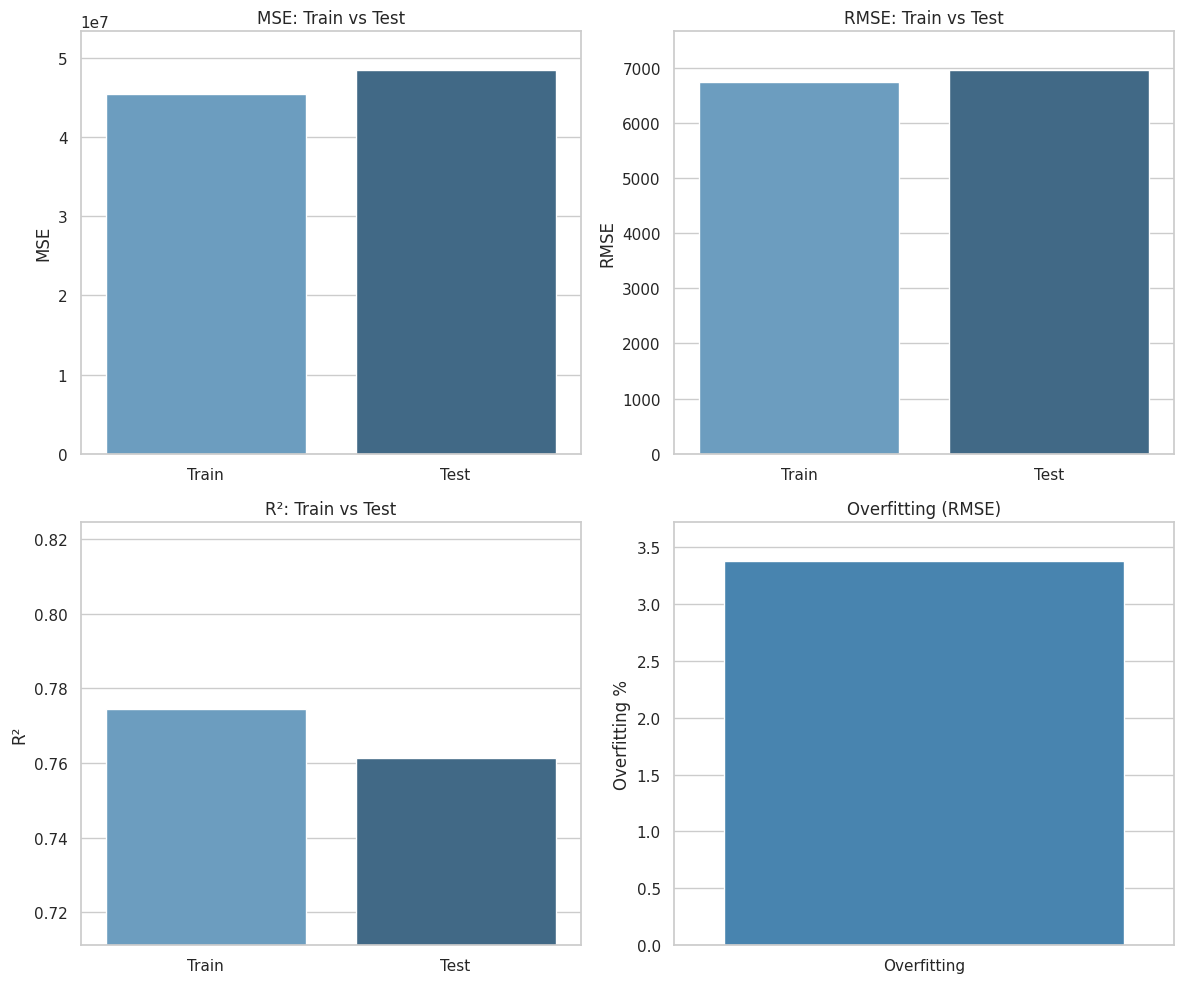

In [ ]:
# Listado de métricas para cada gráfico
metrics = ['MSE', 'RMSE', 'R²', 'Overfitting']
train_values = [mse_train_bal, rmse_train_bal, r2_train_bal, overfitting_bal]  # Entrenamiento
test_values = [mse_test_bal, rmse_test_bal, r2_test_bal, overfitting_bal]  # Prueba

# Configuración general de Seaborn
sns.set(style="whitegrid")  # Estilo de fondo blanco con cuadrícula

# Crear las gráficas
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# MSE Train vs Test
sns.barplot(x=['Train', 'Test'], y=[mse_train_bal, mse_test_bal], ax=ax[0, 0], palette="Blues_d")
ax[0, 0].set_title('MSE: Train vs Test')
ax[0, 0].set_ylabel('MSE')
ax[0, 0].set_ylim(0, max(mse_train_bal, mse_test_bal) * 1.1)

# RMSE Train vs Test
sns.barplot(x=['Train', 'Test'], y=[rmse_train_bal, rmse_test_bal], ax=ax[0, 1], palette="Blues_d")
ax[0, 1].set_title('RMSE: Train vs Test')
ax[0, 1].set_ylabel('RMSE')
ax[0, 1].set_ylim(0, max(rmse_train_bal, rmse_test_bal) * 1.1)

# R² Train vs Test
sns.barplot(x=['Train', 'Test'], y=[r2_train_bal, r2_test_bal], ax=ax[1, 0], palette="Blues_d")
ax[1, 0].set_title('R²: Train vs Test')
ax[1, 0].set_ylabel('R²')
ax[1, 0].set_ylim(min(r2_train_bal, r2_test_bal) - 0.05, max(r2_train_bal, r2_test_bal) + 0.05)

# Overfitting (solo de los valores de RMSE)
sns.barplot(x=['Overfitting'], y=[overfitting_bal], ax=ax[1, 1], palette="Blues_d")
ax[1, 1].set_title('Overfitting (RMSE)')
ax[1, 1].set_ylabel('Overfitting %')
ax[1, 1].set_ylim(0, overfitting_bal * 1.1)  # No es necesario usar max()

# Ajustes en el gráfico
plt.tight_layout()
plt.show()

<ipython-input-57-9aff9744a681>:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


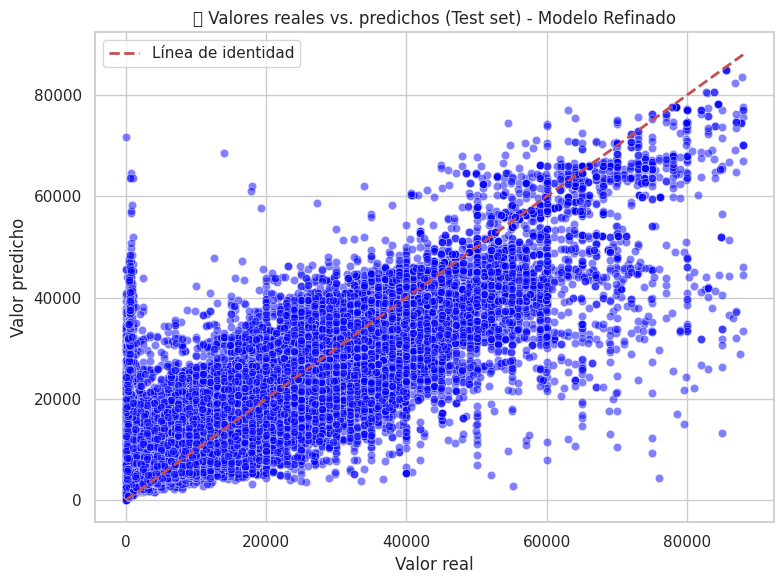

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graficar valores reales vs predichos para el conjunto de prueba (Test set)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test_bal, alpha=0.5, color='blue')  # Usar las predicciones del modelo balanceado refinado
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Línea de identidad')  # Línea de identidad
plt.title('📈 Valores reales vs. predichos (Test set) - Modelo Refinado')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



**📊 Analysis of the Plot: Actual vs. Predicted Values (Test set)**

This plot compares the actual vehicle prices with the predicted values from your refined model. Here's what we can observe:

**✅ Strengths:**
**Good overall alignment:**

Most points are clustered around the identity line (dashed red line), which indicates the model is generally accurate.

Clear linear trend: As the actual price increases, the predicted price tends to increase as well, showing that the model captures the underlying relationship between features and the target.

**⚠️ Points to watch:**

Wider spread at higher prices: There's more dispersion for higher price values, suggesting the model is less accurate in that range—possibly due to fewer high-price examples or more variability among them.

Some outliers: There are a few points far from the red line, which may indicate specific instances where the model underperforms (e.g., very rare or unusual vehicles).

**✅ Conclusion:**

The model performs well overall, especially in the mid to lower price ranges. For further improvement:

Analyze high-error predictions individually.

Consider techniques like log-transforming the target variable (if not already done).

Test more robust models or fine-tune hyperparameters for better high-end prediction

 1. year
 2. cylinders
 3. odometer
 4. manufacturer_alfa-romeo
 5. manufacturer_aston-martin
 6. manufacturer_audi
 7. manufacturer_bmw
 8. manufacturer_buick
 9. manufacturer_cadillac
10. manufacturer_chevrolet
11. manufacturer_chrysler
12. manufacturer_datsun
13. manufacturer_dodge
14. manufacturer_ferrari
15. manufacturer_fiat
16. manufacturer_ford
17. manufacturer_gmc
18. manufacturer_harley-davidson
19. manufacturer_honda
20. manufacturer_hyundai
21. manufacturer_infiniti
22. manufacturer_jaguar
23. manufacturer_jeep
24. manufacturer_kia
25. manufacturer_land rover
26. manufacturer_lexus
27. manufacturer_lincoln
28. manufacturer_mazda
29. manufacturer_mercedes-benz
30. manufacturer_mercury
31. manufacturer_mini
32. manufacturer_mitsubishi
33. manufacturer_morgan
34. manufacturer_nissan
35. manufacturer_pontiac
36. manufacturer_porsche
37. manufacturer_ram
38. manufacturer_rover
39. manufacturer_saturn
40. manufacturer_subaru
41. manufacturer_tesla
42. manufacturer_toyota
43. manu

<ipython-input-58-bcba540469d3>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
<ipython-input-58-bcba540469d3>:26: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


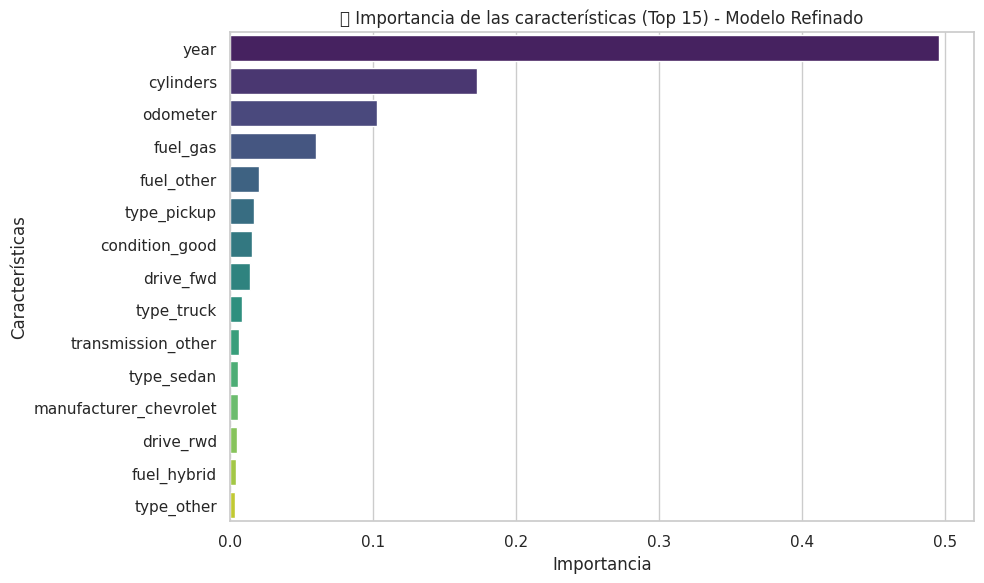

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variables consideradas por el modelo
variables_modelo = list(X_train.columns)

# Mostrarlas
for i, var in enumerate(variables_modelo, 1):
    print(f"{i:2d}. {var}")

# Importancia de características
importances = rf_balanceado_refinado.feature_importances_  # Usamos el modelo balanceado refinado
features = X_train.columns

# Crear un DataFrame con la importancia
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)  # Top 15

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('🌟 Importancia de las características (Top 15) - Modelo Refinado')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.tight_layout()
plt.show()


The graph shows the importance of the top 15 most relevant features in a refined prediction model, likely related to vehicle pricing or valuation. Here are some key observations:

**Most influential variables:**

year (vehicle year) and cylinders are the most impactful features in the model, which makes sense as they are direct indicators of a car's value and performance.

odometer (mileage) is also highly relevant, as it directly reflects the vehicle's wear and tear.

**Fuel and vehicle type:**

Variables like fuel_gas (gasoline), fuel_hybrid, and fuel_other (other fuel types) show that the energy source influences the prediction.

type_pickup, type_truck, and type_sedan stand out as significant categories, suggesting the model effectively differentiates between vehicle styles or uses.

**Other notable features:**

condition_good (good condition) has a moderate impact, highlighting the importance of maintenance.

drive_fwd (front-wheel drive) and drive_rwd (rear-wheel drive) also appear, though with less weight.

**Notable absences:**

Variables like manufacturer_ford or manufacturer_toyota are missing, which might indicate that other brands (e.g., manufacturer_chevrolet) have a more distinctive effect in this model.

<ipython-input-59-06929cb00b00>:15: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


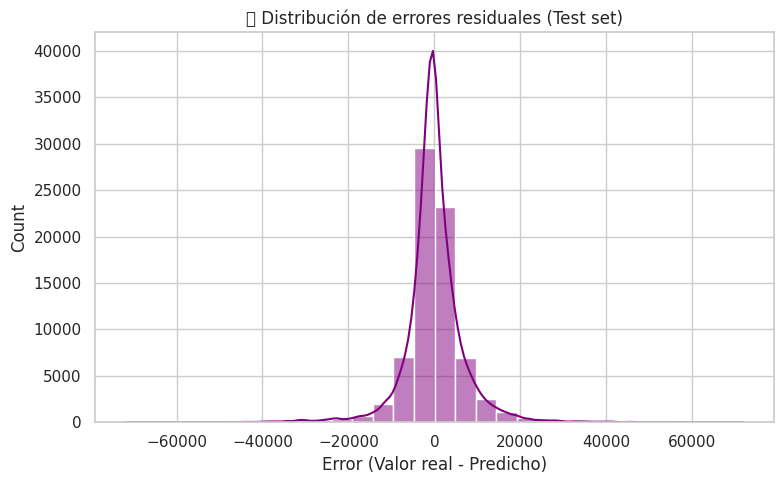

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cálculo de los residuos
residuals = y_test - y_pred_test_bal  # Asegúrate de que 'y_pred_test_bal' corresponda al modelo correcto

# Graficar la distribución de los residuos
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title('📊 Distribución de errores residuales (Test set)')
plt.xlabel('Error (Valor real - Predicho)')
plt.grid(True)

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()


✅ **Centered around zero:**

Most of the residuals are close to 0, which indicates that the model doesn't show systematic bias — it's not consistently overpredicting or underpredicting.

✅ **Roughly symmetrical shape:**

The distribution resembles a bell curve, suggesting that the errors are evenly spread around the true values — a sign of a well-behaved model.

⚠️ **The tails**

The tails are not extremely long, but there is some dispersion at the extremes.
This is not necessarily a bad thing, but:

It could indicate outliers or particular cases that are hard to predict.

It’s worth reviewing the observations with the largest errors to see if there’s any pattern.

# Exportar el pickle

In [ ]:
import pickle

# Guardar el modelo en un archivo pickle
with open('rf_balanceado_refinado.pkl', 'wb') as f:
    pickle.dump(rf_balanceado_refinado, f)